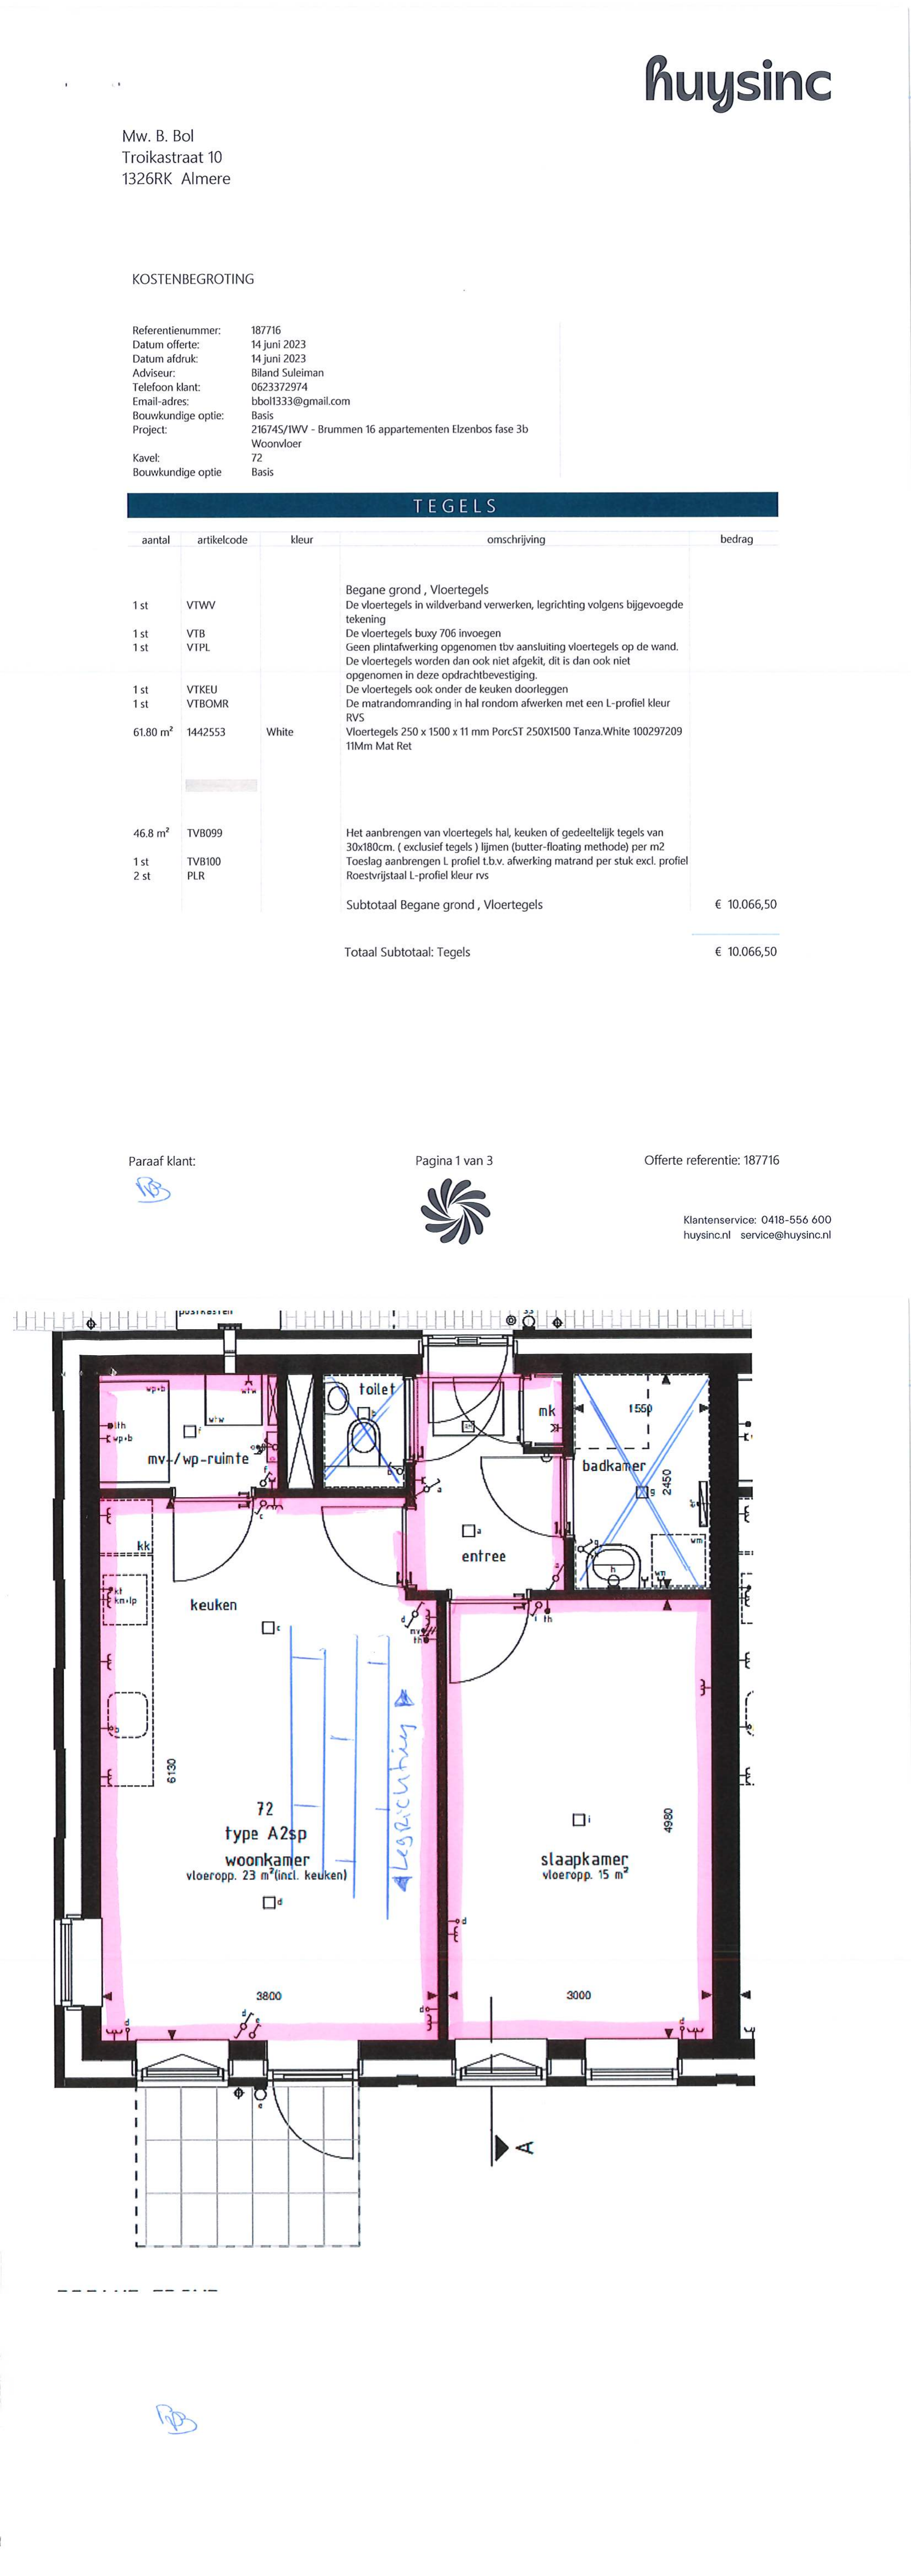

In [2]:
from textgrad.autograd import MultimodalLLMCall
from textgrad.loss import ImageQALoss
from pdf2image import convert_from_path
from dotenv import load_dotenv
from PIL import Image
import textgrad as tg
import numpy as np
import io

# Local PDF path
pdf_path = "pdf/187716-1 Klantorder definitief.pdf"

# Convert all pages of the PDF to images
images = convert_from_path(pdf_path)

# Extract pages 2 and 5 (index 1 and 4, since indexing starts at 0)
page_2 = images[2]  # Page 2
page_5 = images[5]  # Page 5

# Create a new image with both pages (side by side or stacked vertically)
# Here, we are stacking them vertically
combined_width = max(page_2.width, page_5.width)
combined_height = page_2.height + page_5.height

# Create a new image with a white background
combined_image = Image.new("RGB", (combined_width, combined_height), "white")

# Paste the two images into the combined image
combined_image.paste(page_2, (0, 0))  # Paste page 2 at the top
combined_image.paste(page_5, (0, page_2.height))  # Paste page 5 below page 2

# Save the combined image into a BytesIO buffer
combined_buffer = io.BytesIO()
combined_image.save(combined_buffer, format='PNG')

# Get the raw image data from the buffer
combined_image_data = combined_buffer.getvalue()

# Open the combined image from the raw bytes
Image.open(io.BytesIO(combined_image_data))


In [3]:
load_dotenv()
tg.set_backward_engine("gpt-4o", override=True)

In [25]:
image_variable = tg.Variable(combined_image_data, role_description="image with a table and a construction drawing, both in Dutch", requires_grad=False)
question_string = "Try to detect which part in the table contains info about which part of the construction image. Only include what part of the table concerns what part of the drawing"
question_variable = tg.Variable(question_string, role_description="question", requires_grad=True)

response = MultimodalLLMCall("gpt-4o")([image_variable, question_variable])
response

Variable(value=The table in the document provides details about the flooring (vloertegels) for the construction project. Here's how the table relates to the construction image:

1. **Begane grond, Vloertegels**: This refers to the floor tiles for the ground floor, which includes areas like the woonkamer (living room), keuken (kitchen), and slaapkamer (bedroom) as shown in the floor plan.

2. **Vloertegels 250 x 1500 x 11 mm**: These are the specific dimensions and type of floor tiles to be used throughout the areas marked in the floor plan.

3. **Het aanbrengen van vloertegels hal, keuken of gedeeltelijk tegels van 30x60/80cm**: This indicates the installation of floor tiles in the hall and kitchen, which are visible in the floor plan.

The table provides a cost estimate for these flooring installations, which are directly related to the areas shown in the construction image., role=response from the language model, grads=set())

In [27]:
loss_fn = ImageQALoss(
    evaluation_instruction="Does this seem like a extensive and complete answer? Criticize. Do not provide a new answer.",
    engine="gpt-4o"
)
loss = loss_fn(question=question_variable, image=image_variable, response=response)
loss

Variable(value=The answer provides a basic connection between the table and the construction image, but it lacks depth and specificity. It could be improved by:

1. **Detailing Specific Areas**: The answer should specify which parts of the floor plan correspond to each item in the table, such as exact locations for different tile sizes.

2. **Clarifying Measurements**: It should explain how the measurements in the table relate to the dimensions in the floor plan.

3. **Explaining Terms**: Some terms are in Dutch, and a brief explanation or translation would help clarify their relevance to the image.

4. **Cost Analysis**: The answer could include a brief analysis of the cost implications mentioned in the table.

Overall, the answer needs more detailed connections and explanations to be considered extensive and complete., role=evaluation of the response from the language model, grads=set())

In [28]:
optimizer = tg.TGD(parameters=[response])
loss.backward()
optimizer.step()
print(response.value)

The table in the document provides detailed information about the flooring (vloertegels) for the construction project. Here's how the table relates to the construction image:

1. **Begane grond, Vloertegels (Ground Floor, Floor Tiles)**: This section refers to the floor tiles for the ground floor, including specific areas like the woonkamer (living room), keuken (kitchen), and slaapkamer (bedroom) as shown in the floor plan. The tiles are intended for these main living areas.

2. **Vloertegels 250 x 1500 x 11 mm**: These dimensions specify the type of floor tiles to be used. The large format tiles are likely intended for the woonkamer and keuken, providing a seamless and modern look.

3. **Het aanbrengen van vloertegels hal, keuken of gedeeltelijk tegels van 30x60/80cm (Installation of floor tiles in the hall, kitchen, or partially with tiles of 30x60/80cm)**: This indicates that smaller tiles may be used in the hall and possibly in parts of the kitchen, as visible in the floor plan.

